# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd

# For Plotting
import matplotlib.pyplot as plt
import plotly.express as px

# sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge

# surprise
!pip install scikit-surprise
import surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3096322 sha256=893dba4376d4e39177b8ac948cbd304cb0fc7f4b5e621d764116fc0b24889f62
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


# Read Data and Visualizations

In [2]:
# Read Data
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv( "u.data", sep = "\t", names = columns, encoding="latin-1",)
ratings.head(3)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [3]:
print(ratings.isnull().sum())
duplicate_rows_ratings = ratings[ratings.duplicated()]
print("Number of duplicated rows: ", duplicate_rows_ratings.shape)

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
Number of duplicated rows:  (0, 4)


In [4]:
# Plotting
fig = px.bar(ratings['rating'].value_counts(normalize=True),
            labels={'value':'Count (Percentage of Total)', 'index': 'Movie Ratings'},
            width=800,
            height=400,
            title = "Movie Ratings Count")
fig.update_layout(showlegend=False)
fig.show()

In [5]:
# Number of users and movies
N = len(ratings['user_id'].unique())
M = len(ratings['movie_id'].unique())

print(f'Number of users  : {N}')
print(f'Number of movies : {M}')

Number of users  : 943
Number of movies : 1682


A recommender system has two entities which are users and items. Here we have n users and m movies. The goal of our recommendation system is to build an n*m matrix called as the utility matrix which consists of the ratings or preferences for each user-item pair.

In [6]:
print(f'Fraction of non-missing ratings in utility matrix : {round(len(ratings) / (N*M), 5)}')

Fraction of non-missing ratings in utility matrix : 0.06305


In [7]:
print(f'Average number of ratings per user : {round(len(ratings) / N)}')
print(f'Average number of ratings per movie: {round(len(ratings) / M)}')

Average number of ratings per user : 106
Average number of ratings per movie: 59


In [8]:
# Train test split
X = ratings.copy()
y = ratings['user_id']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=311)
X_train.shape, X_valid.shape

((60000, 4), (40000, 4))

In [9]:
# Utility matrixes for train and test
user_mapper = dict(zip(np.unique(ratings['user_id']), list(range(N))))
item_mapper = dict(zip(np.unique(ratings['movie_id']), list(range(M))))

In [10]:
# Helper function to create utility matrix
def create_utility_matrix(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val['user_id']]
        m = item_mapper[val['movie_id']]
        Y[n, m] = val["rating"]

    return Y

In [11]:
# create train and validation matrices using function
train_matrix = create_utility_matrix(X_train, N, M)
test_matrix = create_utility_matrix(X_valid, N, M)

In [12]:
print(f'Shape of train matrix : {train_matrix.shape}')
print(f'Shape of test matrix  : {test_matrix.shape}')

Shape of train matrix : (943, 1682)
Shape of test matrix  : (943, 1682)


In [13]:
# Helper functions to calculate RMSE
def error(Y1, Y2):
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))

def evaluate(pred_Y, train_matrix, test_matrix, model_name="Global Average"):
    print("%s Train RMSE : %0.5f" % (model_name, error(pred_Y, train_matrix)))
    print("%s Test RMSE  : %0.5f" % (model_name, error(pred_Y, test_matrix)))

In [14]:
# Predict every rating as the global average
global_avg = np.nanmean(train_matrix)
pred_global_avg = np.zeros(train_matrix.shape) + global_avg

# Evaluate
evaluate(pred_global_avg, train_matrix, test_matrix, model_name = "Global Average")

Global Average Train RMSE : 1.12921
Global Average Test RMSE  : 1.12033


In [15]:
# Predict every rating as the user average for each user
user_avg = np.nanmean(train_matrix, axis=1)
pred_user_avg = np.tile(user_avg[:, None], (1, M))

# Evaluate
evaluate(pred_user_avg, train_matrix, test_matrix, model_name = "User Average")

User Average Train RMSE : 1.03048
User Average Test RMSE  : 1.03913


In [16]:
# Predict every rating as the movie average for each movie
movie_avg = np.nanmean(train_matrix, axis=0)
pred_movie_avg = np.tile(movie_avg[None, :], (N,1))

evaluate(pred_movie_avg, train_matrix, test_matrix, model_name = "Movie Average")

Movie Average Train RMSE : 0.99558
Movie Average Test RMSE  : 1.02444


<ipython-input-16-33a0b630a0b3>:2: RuntimeWarning:

Mean of empty slice



In [17]:
# Predict every rating as the per-user and per-movie average
pred_user_movie_avg = (user_avg[:, None] + movie_avg[None, :])/2
evaluate(pred_user_movie_avg, train_matrix, test_matrix, model_name = "User and Movie Average")

User and Movie Average Train RMSE : 0.96255
User and Movie Average Test RMSE  : 0.97892


In [18]:
# Remove columns where all entries are NaN
KNN_train_matrix = train_matrix[:,~np.all(np.isnan(train_matrix), axis=0)]
KNN_test_matrix = test_matrix[:,~np.all(np.isnan(train_matrix), axis=0)]

imputer = KNNImputer(n_neighbors=5)
knn_preds = imputer.fit_transform(KNN_train_matrix)

# Evaluate
evaluate(knn_preds, KNN_train_matrix, KNN_test_matrix, model_name = "KNN")

KNN Train RMSE : 0.00000
KNN Test RMSE  : 1.04102


In [19]:
# Read/load Data
ratings_drop = ratings.drop(columns = "timestamp")
reader = Reader()
df = Dataset.load_from_df(ratings_drop, reader)
trainset, testset = surprise.model_selection.train_test_split(df, test_size = 0.4, random_state = 311)

In [20]:
# read in data for u.item (movie )
columns = [
    "movie_id",
    "movie title",
    "release date",
    "video release date",
    "IMDb URL",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

movies_data = pd.read_csv('u.item' ,sep="|", names = columns, encoding="latin-1",)

In [21]:
#take only the movie genre attributes
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
movie_genres = movies_data[genres]
movie_genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


# Hybrid

In [22]:
from surprise import AlgoBase
from surprise import PredictionImpossible
import heapq
from sklearn.metrics.pairwise import linear_kernel

## Content Based Filtering Part

In [23]:
class ContentBasedRecSysKNN(AlgoBase):

    def __init__(self, k=5, movie_data=None, sim_options={}):
        AlgoBase.__init__(self)
        self.k = k
        self.movie_data = movie_data

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        self.compute_genre_similarities()

        return self

    def estimate(self, u, i):
        """
        Estimate function: evaluate the ratings for an user & item
        Process is:
            - gather the ratings for the user u
            - from the similarities (on items) between item i and the items
            from the ratings gathered (neighboring items)
            - order these neighbors
            - calculate the average simmilarities score weighted by user ratings
        Args
            u: current user
            i: current item
        Returns
            predicted ratings
        """
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')

        # Build up similarity scores between this item and everything the user rated
        neighbors = []
        for rating in self.trainset.ur[u]:
            genre_similarity = self.genre_similarities[i,rating[0]]
            neighbors.append( (genre_similarity, rating[1]) )

        # Extract the top-K most-similar ratings (k is set at init)
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])

        # Compute average sim score of K neighbors weighted by user ratings
        sim_total = weighted_sum = 0
        for (sim_score, rating) in k_neighbors:
            if (sim_score > 0):
                sim_total += sim_score
                weighted_sum += sim_score * rating

        if (sim_total == 0):
            raise PredictionImpossible('No neighbors')

        predicted_rating = weighted_sum / sim_total

        return predicted_rating

    def compute_genre_similarities(self):
        # compute similarities
        genre_columns = self.movie_data.columns[6:-1]
        genres = self.movie_data[genre_columns]
        # calculate cosine similarity using linear_kernel from sklearn
        self.genre_similarities = linear_kernel(genres, genres)
        return self

In [24]:
algo_content = ContentBasedRecSysKNN(movie_data=movies_data)

In [25]:
trainset, testset = surprise.model_selection.train_test_split(df, test_size=0.4, random_state=311)
algo_content.fit(trainset)
train_preds = algo_content.test(trainset.build_testset())
test_preds = algo_content.test(testset)
content_train_rmse = accuracy.rmse(train_preds, verbose=True)
content_test_rmse = accuracy.rmse(test_preds, verbose=True)

RMSE: 0.9552
RMSE: 1.1460


In [26]:
content_train_fcp = accuracy.fcp(train_preds, verbose=True)
content_test_fcp = accuracy.fcp(test_preds, verbose=True)

FCP:  0.5910
FCP:  0.4403


## Collaborative Filtering Part

In [27]:
k = 5
algo_colab_filter_SVD = SVD(n_factors = k, random_state=311)
trainset, testset = surprise.model_selection.train_test_split(df, test_size=0.4, random_state=311)
algo_colab_filter_SVD.fit(trainset)
train_preds = algo_colab_filter_SVD.test(trainset.build_testset())
test_preds = algo_colab_filter_SVD.test(testset)

collab_train_rmse = accuracy.rmse(train_preds, verbose=True)
collab_test_rmse = accuracy.rmse(test_preds, verbose=True)

RMSE: 0.9006
RMSE: 0.9446


In [28]:
collab_train_fcp = accuracy.fcp(train_preds, verbose=True)
collab_test_fcp = accuracy.fcp(test_preds, verbose=True)

FCP:  0.7334
FCP:  0.7018


## Hybrid Filtering Part

In [29]:
class HybridRecSysAlgorithm(AlgoBase):

    def __init__(self, algorithms, weights, sim_options={}):
        AlgoBase.__init__(self)
        self.algorithms = algorithms
        self.weights = weights

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        for algorithm in self.algorithms:
            algorithm.fit(trainset)

        return self

    def estimate(self, u, i):

        sum_scores = 0
        sum_weights = 0

        for idx in range(len(self.algorithms)):
            try:
                sum_scores += self.algorithms[idx].estimate(u, i) * self.weights[idx]
                sum_weights += self.weights[idx]
            except:
                continue
        try:
            return sum_scores / sum_weights
        except:
            return 0

In [30]:
hybrid = HybridRecSysAlgorithm([algo_colab_filter_SVD, algo_content], weights = [0.5, 0.5])

In [31]:
trainset, testset = surprise.model_selection.train_test_split(df, test_size=0.4, random_state=311)
hybrid.fit(trainset)
train_preds = hybrid.test(trainset.build_testset())
test_preds = hybrid.test(testset)

hybrid_train_rmse = accuracy.rmse(train_preds, verbose=True)
hybrid_test_rmse = accuracy.rmse(test_preds, verbose=True)

RMSE: 0.8819
RMSE: 0.9991


In [32]:
hybrid_train_fcp = accuracy.fcp(train_preds, verbose=True)
hybrid_test_fcp = accuracy.fcp(test_preds, verbose=True)

FCP:  0.7513
FCP:  0.6419


### Evaluation of RMSE values of each model

In [33]:
labels = ['Training', 'Testing']
content_values = [content_train_rmse, content_test_rmse]
collab_values = [collab_train_rmse, collab_test_rmse]
hybrid_values = [hybrid_train_rmse, hybrid_test_rmse]

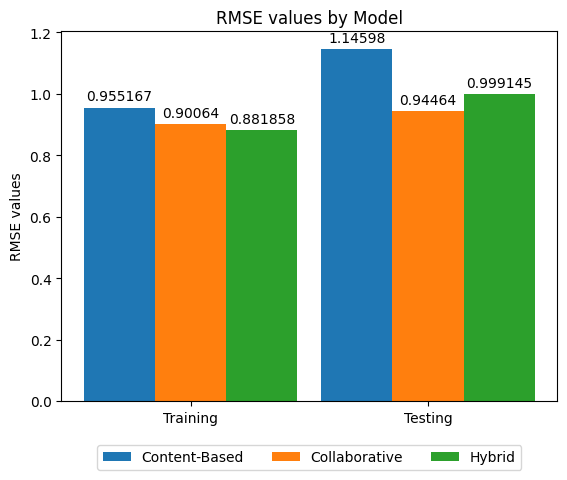

In [34]:
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()

content_rects = ax.bar(x - width, content_values, width, label='Content-Based')
collab_rects = ax.bar(x, collab_values, width, label='Collaborative')
hybrid_rects = ax.bar(x + width, hybrid_values, width, label='Hybrid')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE values')
ax.set_title('RMSE values by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

ax.bar_label(content_rects, padding=3)
ax.bar_label(collab_rects, padding=3)
ax.bar_label(hybrid_rects, padding=3)

plt.show()

In [35]:
labels = ['Training', 'Testing']
content_values = [content_train_fcp, content_test_fcp]
collab_values = [collab_train_fcp, collab_test_fcp]
hybrid_values = [hybrid_train_fcp, hybrid_test_fcp]

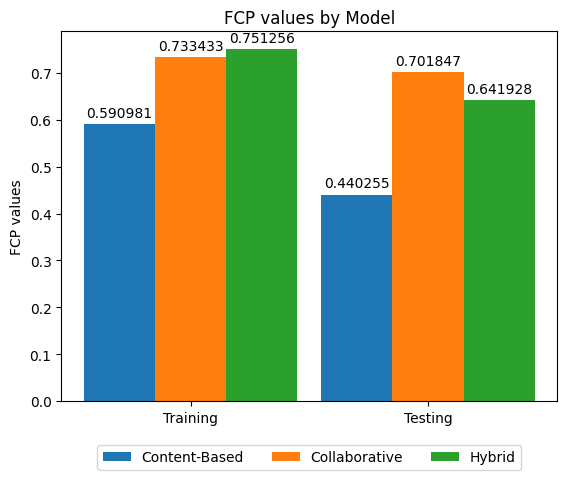

In [36]:
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()

content_rects = ax.bar(x - width, content_values, width, label='Content-Based')
collab_rects = ax.bar(x, collab_values, width, label='Collaborative')
hybrid_rects = ax.bar(x + width, hybrid_values, width, label='Hybrid')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('FCP values')
ax.set_title('FCP values by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

ax.bar_label(content_rects, padding=3)
ax.bar_label(collab_rects, padding=3)
ax.bar_label(hybrid_rects, padding=3)

plt.show()